# Quandl Futures Options Using Tables API
https://data.nasdaq.com/databases/OWF#documentation

As of 2023, the time series interface is deprecated for OptionWorks data from NASDAQ Quandl

Here we see how to obtain the futures and option skew information via the favored tables API

In [2]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl

API_KEY = r'etzm7dS3xxWfVEJaz46j'

In [9]:
os.path.split(os.getcwd())

('/Users/alexhuang/Documents/Academic/FINM 33150',
 'HW1_FuturesSpread_DataCharacterization')

Especially for a tables API, it is important to cache data queries.  Here we have functions that will only grab new data once per day, otherwise returning data from the file cache

In [10]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.makedirs(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_KEY, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )




The IVM table has the implied volatility model values, including futures prices, at-the-money volatility et cetera

In [11]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Creating new data dir /Users/alexhuang/quandl_data_table_downloads/AR
Download finished: 290238259 bytes
Creating symlink: /Users/alexhuang/quandl_data_table_downloads/AR/IVM_20240113.zip -> /Users/alexhuang/quandl_data_table_downloads/AR/IVM_latest.zip


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040000,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550000,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703000,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,BO,BO,1M,2023-07-27,67.346897,0.352890,-0.002929,-0.005976,0.002417,...,-0.024721,0.420288,-0.644045,23.556375,14.352899,-214.004951,-0.222364,0.238453,31.00,31.0


In [12]:
t_ivm.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2',
       'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money',
       'days_expiration', 'days_termination'],
      dtype='object')

The IVS table gives is entore volatility surfaces

In [13]:
t_ivs = fetch_quandl_table('AR/IVS', avoid_download=False)
print(t_ivs.shape)
t_ivs.iloc[[0,1,2,-3,-2,-1],:8]

Download finished: 698685586 bytes
Creating symlink: /Users/alexhuang/quandl_data_table_downloads/AR/IVS_20240113.zip -> /Users/alexhuang/quandl_data_table_downloads/AR/IVS_latest.zip
(5235793, 49)


,exchange_code,futures_code,option_code,expiration,date,dnsvol,p01dvol,p05dvol
0,ICE,M,M,1W,2023-07-27,1.439305,1.445888,1.456649
1,NYX,W,W,6M,2023-07-27,0.176926,0.171437,0.173553
2,NYX,W,W,9M,2023-07-27,0.161198,0.155353,0.156587
5235790,NYX,W,W,Z2025,2023-07-24,0.170749,0.159110,0.159625
5235791,NYX,W,W,Z2025,2023-07-25,0.170686,0.159749,0.159583
5235792,NYX,W,W,Z2025,2023-07-26,0.170663,0.159194,0.159991


In [14]:
t_ivs.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'dnsvol', 'p01dvol', 'p05dvol', 'p10dvol', 'p15dvol', 'p20dvol',
       'p25dvol', 'p30dvol', 'p35dvol', 'p40dvol', 'p45dvol', 'p50dvol',
       'p55dvol', 'p60dvol', 'p65dvol', 'p70dvol', 'p75dvol', 'p80dvol',
       'p85dvol', 'p90dvol', 'p95dvol', 'p99dvol', 'c01dvol', 'c05dvol',
       'c10dvol', 'c15dvol', 'c20dvol', 'c25dvol', 'c30dvol', 'c35dvol',
       'c40dvol', 'c45dvol', 'c50dvol', 'c55dvol', 'c60dvol', 'c65dvol',
       'c70dvol', 'c75dvol', 'c80dvol', 'c85dvol', 'c90dvol', 'c95dvol',
       'c99dvol', 'days_expiration'],
      dtype='object')

Exchanges include CME, ICE and others

In [15]:
t_ivm.groupby('exchange_code')['futures_code'].count()

exchange_code
CBT     886779
CME    1178238
CMX     310979
ICE    1370480
NYM     795067
NYX     361602
Name: futures_code, dtype: int64

The time series of Dec 2024 E-Mini contract futures option skew model values

In [16]:
t_ivm.loc[(t_ivm.exchange_code=='CME') & (t_ivm.futures_code=='ES') & (t_ivm.option_code=='ES')& (t_ivm.expiration=='Z2024')].iloc[[0, 1,-1]].transpose()

,398,1448,1916527
exchange_code,CME,CME,CME
futures_code,ES,ES,ES
option_code,ES,ES,ES
expiration,Z2024,Z2024,Z2024
date,2023-07-27,2023-10-02,2023-07-26
futures,4808.0,4517.0,4838.0
atm,0.160513,0.176705,0.157342
rr25,-0.062816,-0.065095,-0.062253
rr10,-0.127251,-0.127364,-0.126376
fly25,0.002873,-0.000105,0.00308


In [17]:
pd.to_datetime( t_ivm.date , format='%Y-%m-%d')

0         2023-07-27
1         2023-10-02
2         2023-07-27
3         2023-10-02
4         2023-07-27
             ...    
4903140   2020-08-31
4903141   2023-07-20
4903142   2023-07-21
4903143   2023-07-25
4903144   2023-07-26
Name: date, Length: 4903145, dtype: datetime64[ns]

The dates come as strings, here we convert them to more useful objects

In [18]:
fc_fix_date = t_ivm.copy()
fc_fix_date['Date'] = pd.to_datetime( fc_fix_date.date , format='%Y-%m-%d')

In [19]:
fut_curve_data = fc_fix_date.set_index(['exchange_code', 'futures_code','option_code','expiration', 'Date'])
fut_curve_data.sort_index(inplace=True)

In [20]:
es_fut_curve_data = fut_curve_data.loc[('CME','ES','ES')]
es_fut_curve_data.loc['Z2014'].iloc[[0, -1]].transpose()

Date,2013-12-23,2014-12-18
date,2013-12-23,2014-12-18
futures,1802.2,2065.0
atm,0.155901,0.162534
rr25,-0.055657,-0.001957
rr10,-0.108066,-0.0098
fly25,0.002523,0.006448
fly10,0.016919,0.028524
beta1,-0.282516,-0.138761
beta2,0.074599,255.483612
beta3,0.967884,-2246.910245


We can now plot daily futures prices, in this case for about a decade ago

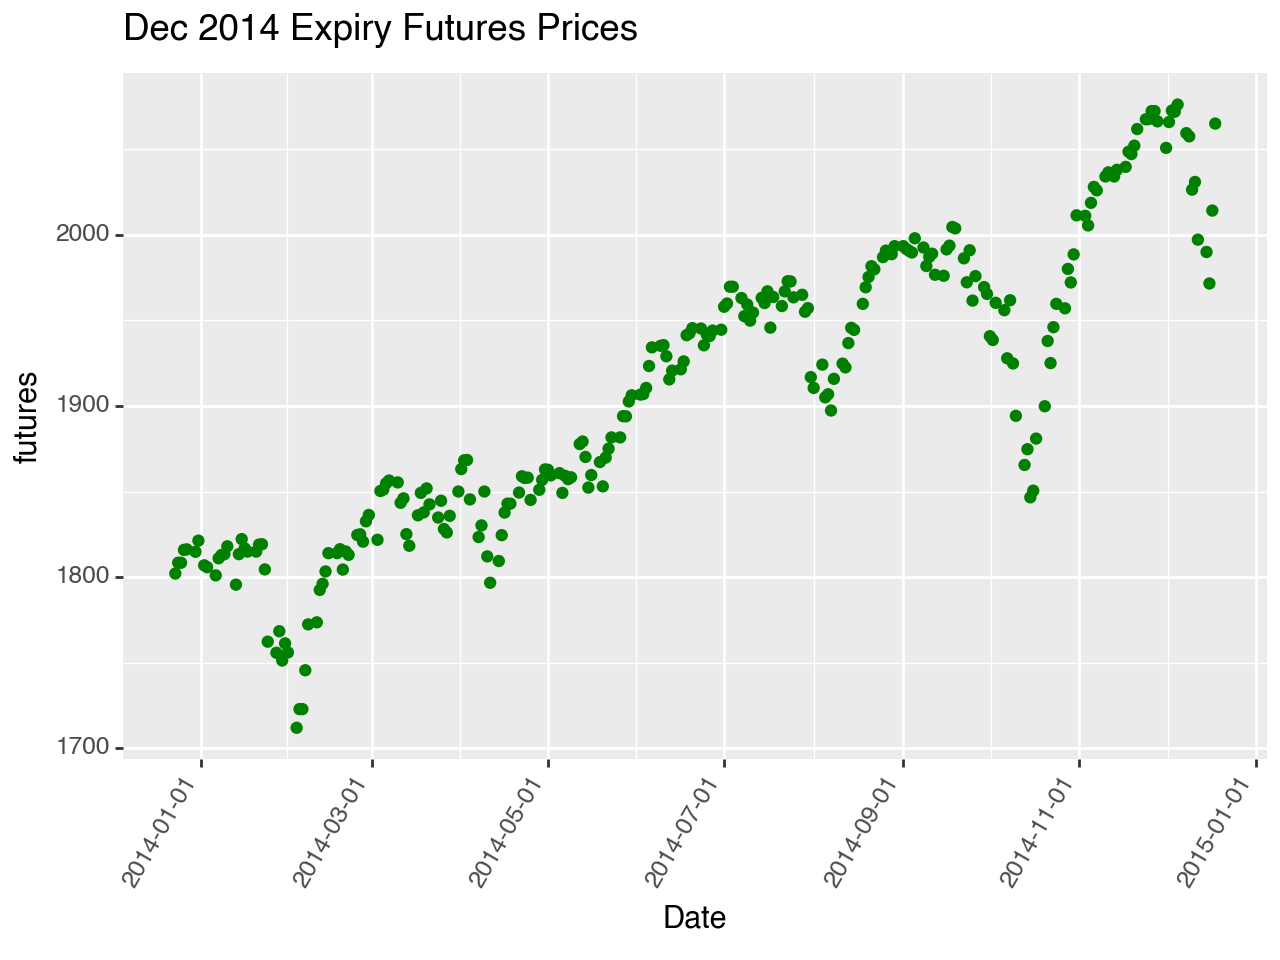

<Figure Size: (640 x 480)>

In [21]:
(
    p9.ggplot(
        es_fut_curve_data.loc['Z2014'].reset_index(),
        p9.aes(x='Date', y='futures')
    )
    + p9.geom_point(color='green')
    + p9.theme(axis_text_x=p9.element_text(rotation=60, hjust=1))
    + p9.ggtitle('Dec 2014 Expiry Futures Prices')
)

### The OptionWorks Volatility Parameterization

In [22]:
def vols(r):
    moneyness = pd.Series(np.linspace(start=r.min_money, stop=r.max_money, num=100))
    vola = r.atm + (r.beta1*moneyness + r.beta2*moneyness**2 + r.beta3*moneyness**3
                     + r.beta4*moneyness**4 + r.beta5*moneyness**5 + r.beta6*moneyness**6)
    vola.name="ImplVol"
    future = r.futures * np.exp(moneyness)
    return pd.DataFrame({"Dec 2014 Emini Future": future, "Moneyness": moneyness, "ImplVol": vola})


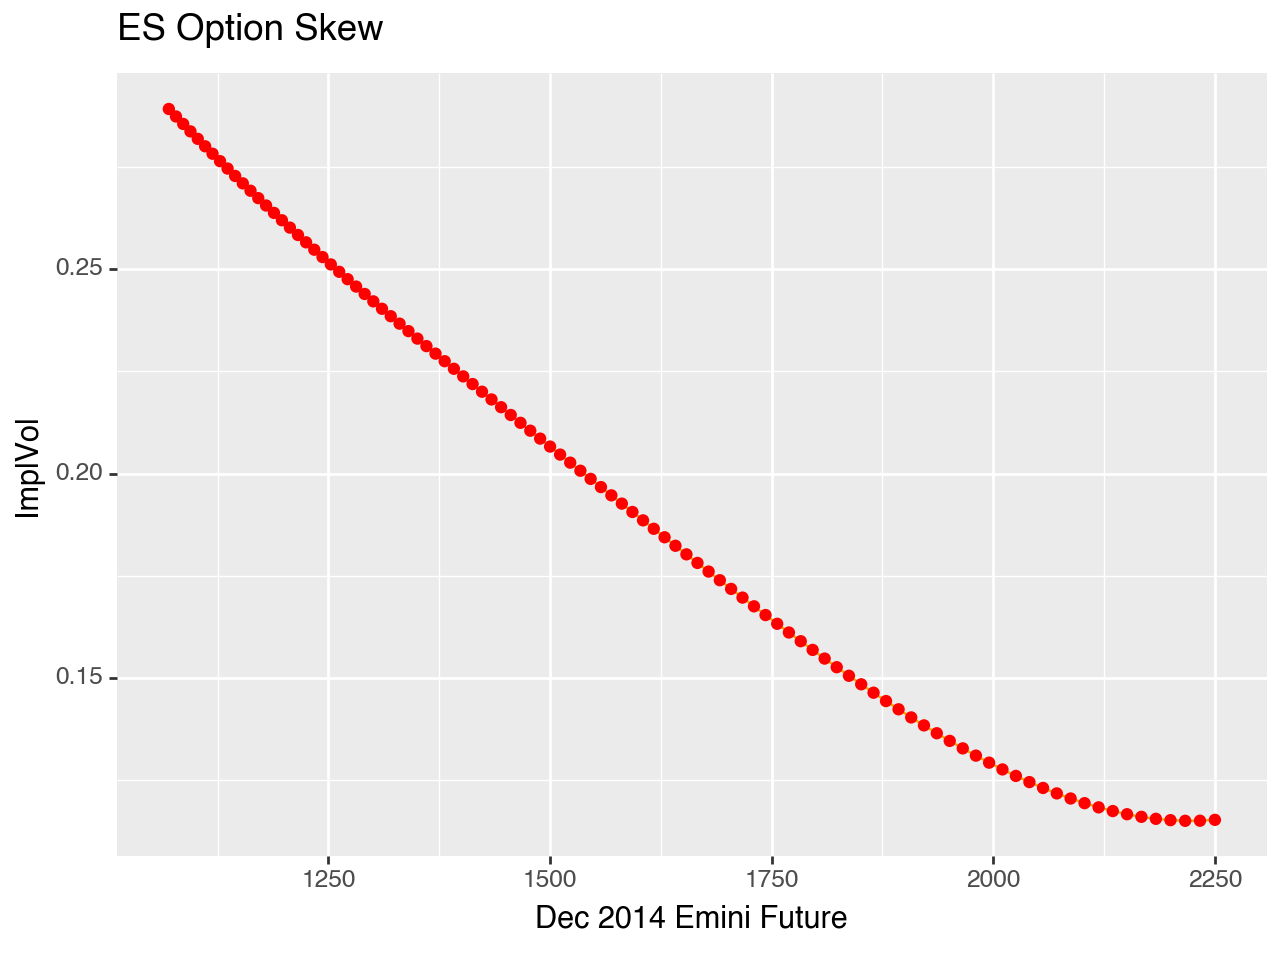

<Figure Size: (640 x 480)>

In [23]:
v = vols(es_fut_curve_data.loc['Z2014'].iloc[0])
(
    p9.ggplot(v, p9.aes(x='Dec 2014 Emini Future', y='ImplVol'))
    + p9.geom_line(color='orange')
    + p9.geom_point(color='red')
    + p9.ggtitle('ES Option Skew')
)